# Online Laplace with a replay buffer

In [1]:
import jax
import optax
import distrax

import numpy as np
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from typing import Callable
from functools import partial
from jax.flatten_util import ravel_pytree
from flax.training.train_state import TrainState

from rebayes.utils import callbacks
from rebayes.utils.utils import tree_to_cpu
from rebayes.sgd_filter import sgd
from rebayes.sgd_filter import replay_sgd as rsgd
from rebayes.datasets import rotating_mnist_data as rmnist

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Replay-buffer SGD

In [3]:
scale = 0.1
prior_cov = 1 / 2000

@partial(jax.jit, static_argnames=("apply_fn",))
def log_likelihood(params, X, y, apply_fn):
    y = y.ravel()
    mean = apply_fn(params, X).ravel()
    prior_std = jnp.sqrt(prior_cov)
    ll = distrax.Normal(mean, prior_std).log_prob(y)
    return ll.sum()
    
@partial(jax.jit, static_argnames=("apply_fn",))
def lossfn_map(params, counter, X, y, apply_fn):
    """
    Lossfunction for regression problems.
    """
    params_flat, _ = ravel_pytree(params)
    
    yhat = apply_fn(params, X).ravel()
    y = y.ravel()
    
    prior_std = jnp.sqrt(prior_cov)
    log_prior = distrax.Normal(0.0, prior_cov).log_prob(params_flat).sum() * 0.0
    
    log_likelihood = distrax.Normal(yhat, scale).log_prob(y)
    log_likelihood = (log_likelihood * counter).sum()
    
    log_joint = log_prior + log_likelihood
    
    return -log_joint

In [39]:
class MLP(nn.Module):
    n_out: int = 1
    n_hidden: int = 100
    activation: Callable = nn.elu

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out, name="last-layer")(x)
        return x

In [66]:
def damp_angle(n_configs, minangle, maxangle):
    t = np.linspace(0, 1.5, n_configs)
    # angles = np.exp(t) * np.sin(35 * t)
    angles = np.sin(35 * t)
    angles = (angles + 1) / 2 * (maxangle - minangle) + minangle + np.random.randn(n_configs) * 2
    
    angles = np.random.randn(n_configs) * 50 + (maxangle + minangle) / 2
    return angles

In [67]:
num_train = None
frac_train = 1.0
target_digit = 2

np.random.seed(314)
data = rmnist.load_and_transform(
    damp_angle, target_digit, num_train, frac_train, sort_by_angle=False
)

ymean, ystd = data["ymean"], data["ystd"]
X_train, Y_train, labels_train = data["dataset"]["train"]
X_test, Y_test, labels_test = data["dataset"]["test"]

In [69]:
model = MLP()
buffer_size = 10
tx = optax.adam(1e-4)
key = jax.random.PRNGKey(314)
agent = rsgd.init_regression_agent(
    key, log_likelihood, model, X_train, tx, buffer_size,
    lossfn=lossfn_map,
    prior_precision=1/prior_cov,
)

In [70]:
callback = partial(callbacks.cb_reg_mc,
                   apply_fn=agent.apply_fn,
                   ymean=ymean, ystd=ystd,
                   agent=agent, X_test=X_train, y_test=Y_train,
                   key=key,
                  )

bel, output_rsgd = agent.scan(X_train, Y_train, progress_bar=True, callback=callback)
bel = jax.block_until_ready(bel)
output_rsgd = tree_to_cpu(output_rsgd)

  0%|          | 0/5958 [00:00<?, ?it/s]

In [74]:
ksize = 25
kernel = np.ones(ksize) / ksize

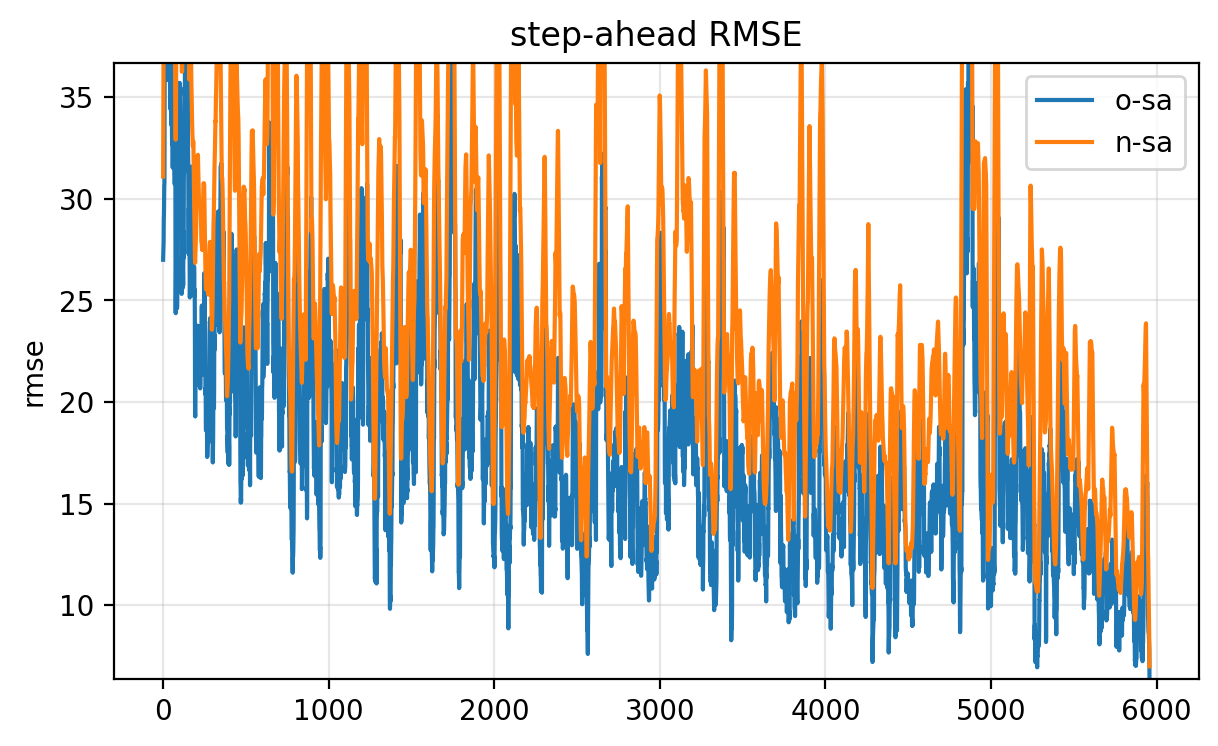

In [75]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_osa = output_rsgd["osa-error"]
err_smooth_nsa = output_rsgd["nsa-error"]

err_smooth_osa = np.convolve(err_smooth_osa, kernel, mode="same")
err_smooth_nsa = np.convolve(err_smooth_nsa, kernel, mode="same")

plt.plot(err_smooth_osa, label="o-sa")
plt.plot(err_smooth_nsa, label="n-sa")

plt.grid(alpha=0.3)

vmin = np.quantile(err_smooth_osa, 0.00)
vmax = np.quantile(err_smooth_osa, 0.99)
plt.ylabel("rmse")
plt.legend()
plt.title("step-ahead RMSE")
plt.ylim(vmin, vmax);

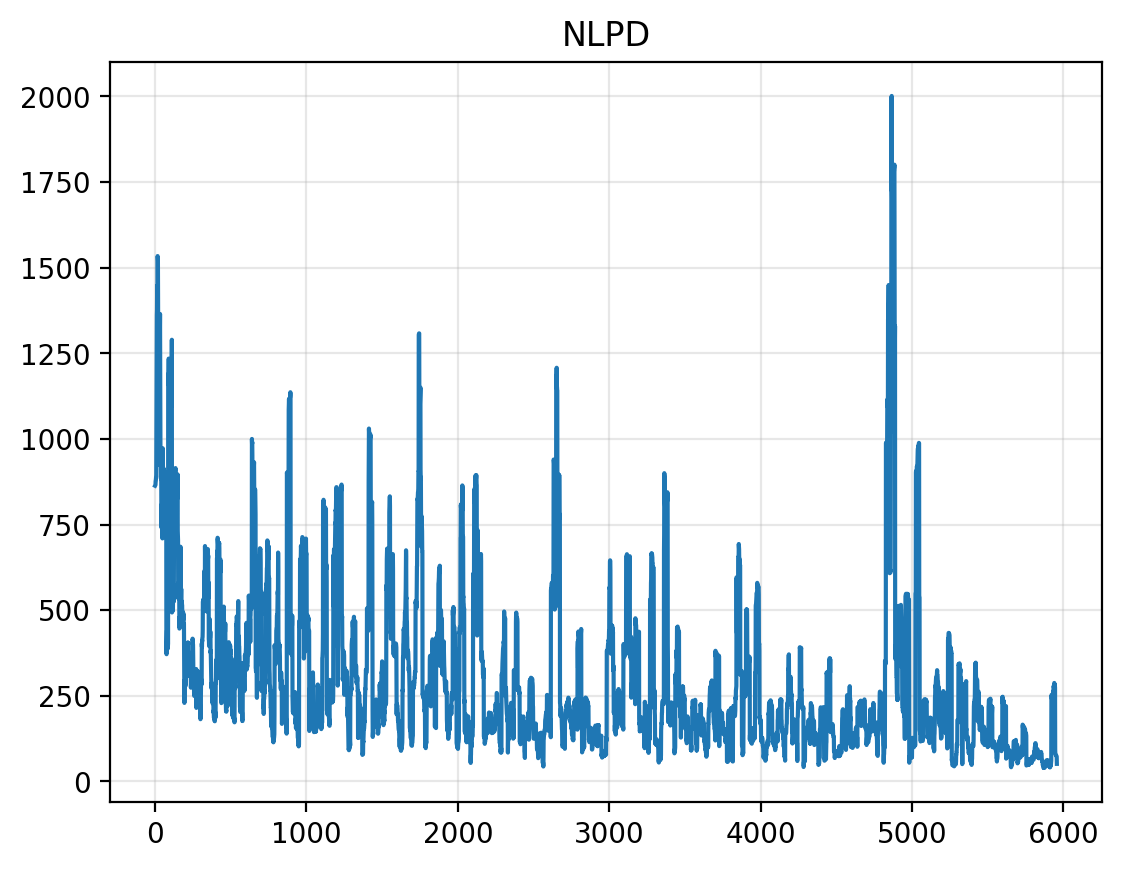

In [76]:
metric_smooth = output_rsgd["nlpd"]
metric_smooth = np.convolve(metric_smooth, kernel, mode="same")
plt.plot(metric_smooth)
plt.title("NLPD")
plt.grid(alpha=0.3)

### Laplace approximation

In [77]:
yhat_samples_test = agent.pred_obs_mc(key, bel, bel.buffer_X, shape=(40,)).squeeze()
yhat_samples_test.mean(axis=0)

Array([-0.56227666, -0.9166536 ,  1.508499  , -2.4317386 , -0.45714432,
       -0.9062754 , -0.1232041 ,  0.93945694,  0.90490407, -0.61045885],      dtype=float32)

In [78]:
model.apply(bel.mean, bel.buffer_X).ravel()

Array([-0.5865941 , -0.977762  ,  1.5124754 , -2.439533  , -0.49066865,
       -0.9505565 , -0.12166969,  0.94413686,  0.90581083, -0.6531124 ],      dtype=float32)

In [79]:
bel.buffer_y.ravel()

Array([-0.58593905, -1.133245  ,  1.2783395 , -2.2694733 , -0.6092377 ,
       -0.77594525,  0.07742468,  1.2669454 ,  1.0452539 , -0.6623995 ],      dtype=float32)

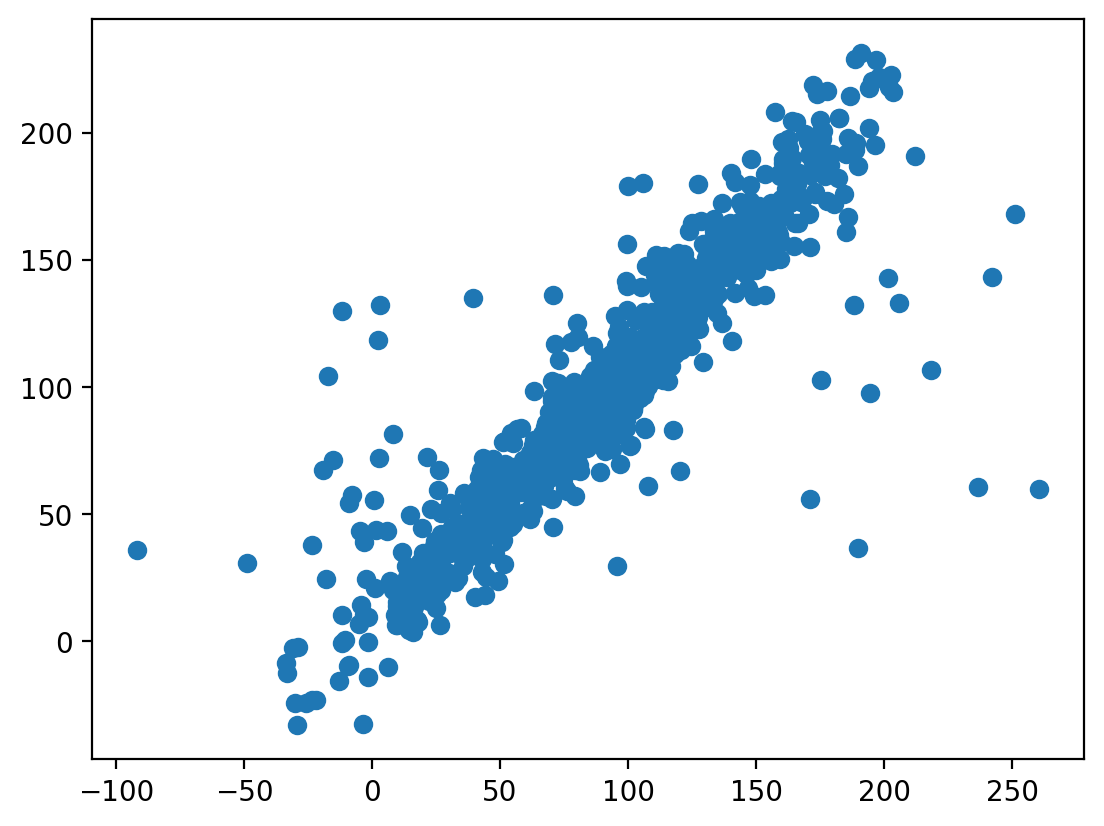

In [80]:
yhat_test = model.apply(bel.mean, X_test).squeeze() * ystd + ymean
y_test = Y_test * ystd + ymean 
plt.scatter(y_test, yhat_test)

In [81]:
# RMSE
jnp.sqrt(jnp.power(y_test - yhat_test, 2).mean())

Array(23.242796, dtype=float32)

---

## Full-batch SGD

In [82]:
key = jax.random.PRNGKey(314)
tx = optax.adam(1e-4)

In [83]:
state = TrainState.create(
    apply_fn=model.apply,
    params=bel.mean,
    tx=tx
)

In [84]:
%%time
num_epochs = 1_000
batch_size = 200

state_final, losses = sgd.train_full(key, num_epochs, batch_size, state, X_train, Y_train, sgd.lossfn)

CPU times: user 39.4 s, sys: 4.51 s, total: 43.9 s
Wall time: 28.1 s


In [85]:
ntest = 1000
ytrue = Y_train[-ntest:]
yhat = model.apply(state_final.params, X_train[-ntest:]).ravel()

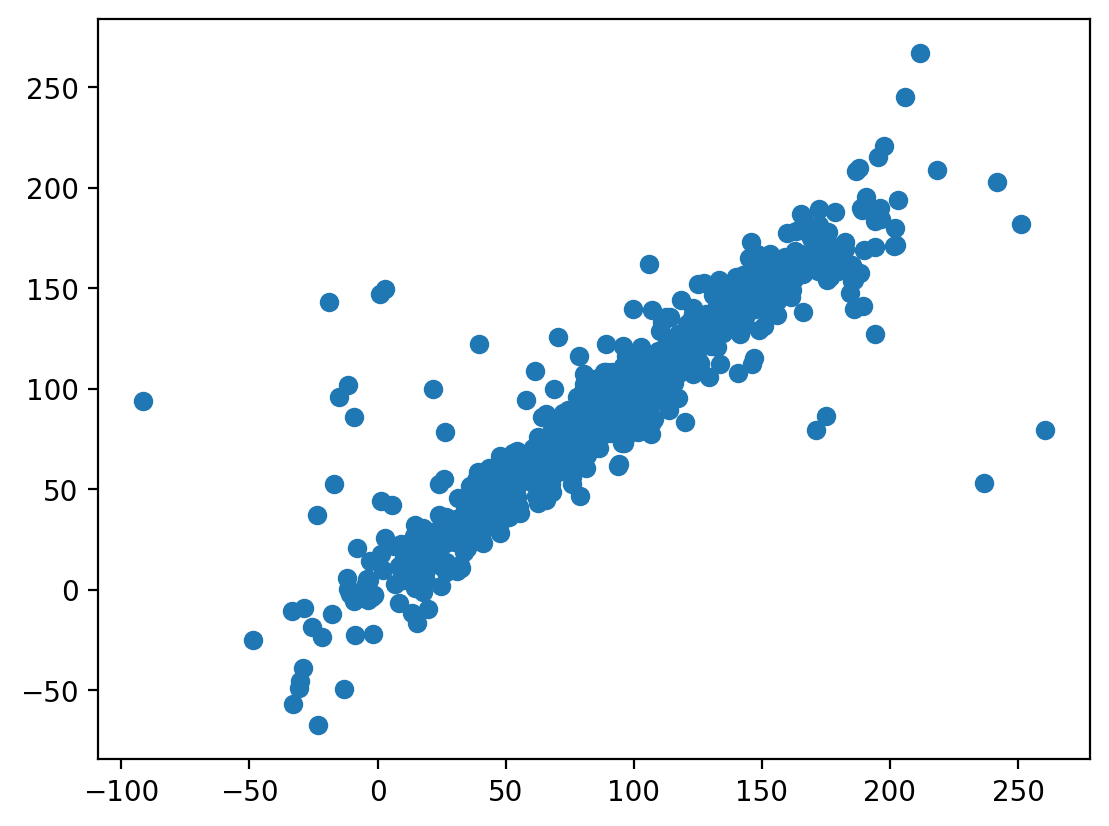

In [86]:
yhat_test = model.apply(state_final.params, X_test).squeeze() * ystd + ymean

y_test = Y_test * ystd + ymean 
plt.scatter(y_test, yhat_test)

In [87]:
jnp.sqrt(jnp.power(y_test - yhat_test, 2).mean())

Array(19.558186, dtype=float32)

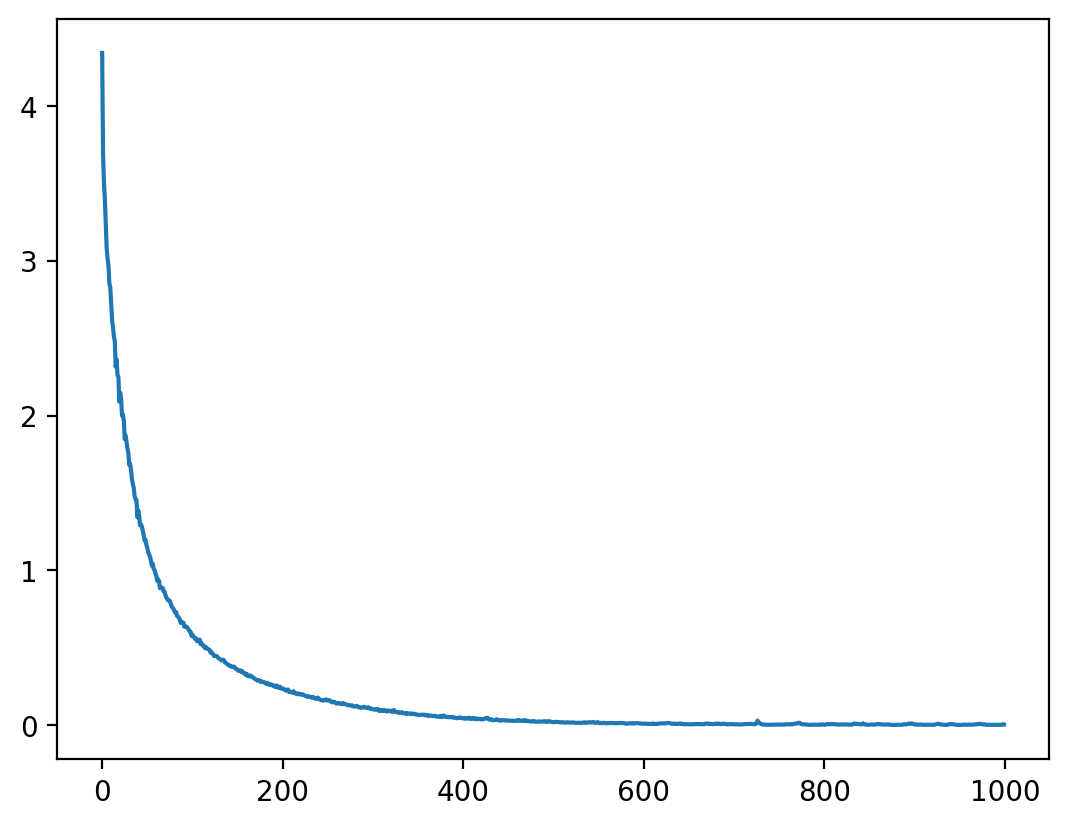

In [88]:
plt.plot(losses["train"])